In [1]:
import os
import pandas
#import itertools
import nibabel as ni
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.spatial import KDTree
#from statsmodels.sandbox.stats.multicomp import multipletests
#from nilearn import image, input_data

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Your git directory here:
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'

import sys
sys.path.insert(0,git_dir)
import HAP_Utils as hap

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# DOWNLOAD INSTRUCTIONS

* Go to http://human.brain-map.org/static/download
* Under the subheading "Complete normalized microarray datasets", click each donor link to download microarray gene expression data for that subject (e.g. H0351.2001)
* Unzip and move these folders to a single location

To get the renormalized sample coordinates:
-----------------------------
* Go to https://github.com/gdevenyi/AllenHumanGeneMNI
* Clone or download the respository

# Inititalize data

In [3]:
# Enter the path for the directory where you stored your file downloads
aba_dir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'

probes = pandas.read_csv(os.path.join(aba_dir,'normalized_microarray_donor9861/Probes.csv'))

#### GET EVERYTHING INTO A GIANT DATAFRAME AND SAVE DONOR INFORMATION FOR REGRESSION

In [4]:

bigsheet = []
xpsheets = sorted(glob(os.path.join(aba_dir,
                                    'normalized_microarray_donor*/MicroarrayExpression.csv'
                                   ))) # collect gene expression data
dids = [x.split('/')[-2].split('donor')[-1] for x in xpsheets] # donor IDs

# Turn each csv into a dataframe, add donor ID, and concatenate into one big DataFrame
for sheet in xpsheets:
    did = sheet.split('/')[-2].split('donor')[-1] # get donor id
    gxp = pandas.read_csv(sheet,header=None)
    gxp.drop(gxp.columns[0],axis=1,inplace=True)
    
    # create dummy variables for donor
    for tid in dids:
        if tid == did:
            gxp.loc['is_%s'%tid] = 1
        else:
            gxp.loc['is_%s'%tid] = 0
    bigsheet.append(gxp)
    print('finished',did)
    
bigdf = pandas.concat(bigsheet,axis=1).transpose()

finished 10021
finished 12876
finished 14380
finished 15496
finished 15697
finished 9861


# Regress out donor effects
Here, we want to remove donor-specific separately for each probe.

In [5]:
# PREP FOR REGRESSION
bigdf.columns = ['col_%s'%x for x in bigdf.columns[:-6]] + bigdf.columns[-6:].tolist()
resid_df = pandas.DataFrame(np.empty_like(bigdf.values),
                            index = bigdf.index, columns=bigdf.columns)
resid_df.iloc[:,-6:] = bigdf.iloc[:,-6:].values

In [6]:
# RUN STATS (took about 5-10 minute on the work computer)
for i,col in enumerate(bigdf.columns[:-6]):
    resid_df.loc[:,col] = smf.ols('%s ~ is_10021 + is_12876 + is_14380 + is_15496 + is_15697'%(col), 
                                  data=bigdf).fit().resid
    if i % 1000 == 0:
        print(i)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000


In [7]:
# SAVE BACK INTO SPREADSHEETS
dfz = {}
for col in resid_df.columns[-6:]:
    did = col.split('_')[-1]
    ddir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/normalized_microarray_donor%s'%did
    refsht = os.path.join(ddir,'MicroarrayExpression.csv')
    print('loading reference csv')
    gxp = pandas.read_csv(refsht,header=None)
    gxp.drop(gxp.columns[0],axis=1,inplace=True)
    ndf = resid_df[resid_df[col]==1][resid_df.columns[:-6]].transpose()                            
    ndf.index = gxp.index                        
    ndf.columns = gxp.columns  
    print('saving new csv')
    #ndf.to_csv(os.path.join(ddir,'MExp_genes_ctr_for_donor'))
    dfz.update({did: ndf})
    print('finished',did)

loading reference csv
saving new csv
finished 10021
loading reference csv
saving new csv
finished 12876
loading reference csv
saving new csv
finished 14380
loading reference csv
saving new csv
finished 15496
loading reference csv
saving new csv
finished 15697
loading reference csv
saving new csv
finished 9861


# Create DataFrames for subsequent use

### Sample reference information with corrected coordinates

In [8]:
donor_key = {'H0351.2002': '10021', 'H0351.2001': '9861',
             'H0351.1009': '12876', 'H0351.1012': '14380',
             'H0351.1015': '15496', 'H0351.1016': '15697'}

In [9]:
# ENTER PATH TO GIT REPOSITORY CONTAINING COORDINATES
coord_pth = '/path/to/coordinate/repository/AllenHumanGeneMNI/'

In [10]:
ref = []
#sasheets = sorted(glob(os.path.join(coord_pth,
#                                    'transformed_points/recombine/*.csv')))
#sasheets = sorted(glob('/data1/users/jvogel/Allen_Human_Brain_Atlas/CORRECT_coords/recombine/*.csv'))
for sheet in sasheets:
    did = donor_key[sheet.split('/')[-1].split('_')[0]]
    sa = pandas.read_csv(sheet)
    sa.loc[:,'donor'] = [did for x in range(len(sa))]
    sa.loc[:,'sample'] = [x for x in range(1,len(sa)+1)]
    ref.append(sa)
SA = pandas.concat(ref).sort_values(['donor','sample'])
SA.index = range(len(SA))

In [75]:
SA.head()

,structure_id,slab_num,well_id,slab_type,structure_acronym,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z,mni_nlin_x,mni_nlin_y,mni_nlin_z,donor,sample,DS
0,4322,10,5705,CX,Cl,"claustrum, left",978619,120,91,71,-29.2,5.8,-2.6,-30.556682,4.815207,-3.825961,10021,1,10021_1
1,4291,10,5713,CX,Acb,"nucleus accumbens, left",998603,103,96,71,-10.1,5.9,-8.4,-11.959526,4.812381,-9.908026,10021,2,10021_2
2,4292,10,5721,CX,Acb,"nucleus accumbens, right",998604,86,95,69,8.9,8.5,-7.4,9.525111,6.206098,-10.330865,10021,3,10021_3
3,4292,11,5729,CX,Acb,"nucleus accumbens, right",999200,87,95,76,7.9,0.8,-6.7,8.037896,-0.206559,-9.481507,10021,4,10021_4
4,4314,11,5737,CX,SI,"substantia innominata, right",992030,79,97,76,16.9,0.9,-9.1,17.459030,-0.798126,-12.156898,10021,5,10021_5


In [11]:
data_dir = os.path.join(git_dir,'Data')
SA.to_csv(os.path.join(data_dir,'MAIN_gcx_wholebrain_info.csv'))

### Find hippocampus coordinates

In [12]:
hipp_structures = ['CA1','CA2','CA3','CA4','DG','S']
hipp_df = pandas.DataFrame(SA[SA.structure_acronym.isin(hipp_structures)], copy=True)
hipp_df.head()

,structure_id,slab_num,well_id,slab_type,structure_acronym,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z,mni_nlin_x,mni_nlin_y,mni_nlin_z,donor,sample
19,4263,17,5707,CX,CA1,"CA1 field, right",1001646,77,89,116,19.5,-42.4,4.3,21.876385,-42.363260,4.710402,10021,20
20,4264,17,5715,CX,CA2,"CA2 field, right",1001641,75,86,115,21.7,-41.2,7.7,23.899152,-40.879051,8.176524,10021,21
21,4265,17,5723,CX,CA3,"CA3 field, right",1001496,76,86,115,20.6,-41.2,7.7,22.703225,-40.994060,8.301460,10021,22
22,4266,17,5731,CX,CA4,"CA4 field, right",1001475,76,87,115,20.6,-41.2,6.6,22.928779,-41.054804,7.141831,10021,23
23,4267,17,5739,CX,DG,"dentate gyrus, right",998739,75,87,115,21.8,-41.2,6.6,24.115367,-40.962119,7.018704,10021,24


### Make sure they are are inside of, or within three mm of, the hippocampus

In [13]:
# Isolate hippocampus
HO = ni.load(os.path.join(data_dir,'HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')).get_data()
hipps = np.zeros_like(HO)
hipps[HO==9] = 1
hipps[HO==19] = 1
hipp_coords = np.where(hipps==1)

In [14]:
# Get XYZ coordinates of each hippocampus samples
sample_coords = []
for i,row in hipp_df.iterrows():
    coords = hap.convert_coords([row['mni_nlin_x'], 
                     row['mni_nlin_y'], 
                     row['mni_nlin_z']], 
                    'xyz')
    sample_coords.append([round(x) for x in coords])

In [15]:
# compute distance shortest distance of each sample

# convert to format that KDTree likes
hipp_cs = [(hipp_coords[0][x],
            hipp_coords[1][x],
            hipp_coords[2][x]) for x in range(len(hipp_coords[0]))]

# make KDTree
tree = KDTree(hipp_cs)

# compute distances
dists = [tree.query(x)[0] for x in sample_coords]

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


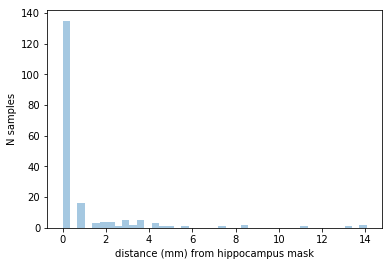

In [16]:
# Make sure most distances are small

plt.close()
sns.distplot(dists, kde=False)
plt.xlabel('distance (mm) from hippocampus mask')
plt.ylabel('N samples')
plt.show()

### Dataframe with Gene expression for (good) hippocampus samples only

In [17]:
# get index of coords that are within 3mm (rounded) to the hippocampus mask
good_ind = [x for x in range(len(dists)) if dists[x] < 3.49] # list indices
good_hipp_df = hipp_df.iloc[good_ind] 


In [29]:
# For some reason, I apparently got rid of another coordinate, 
# so the following will match what was used for analysis in the paper
todrop = good_hipp_df[(good_hipp_df.donor=='14380') & (good_hipp_df['sample']==220)].index
good_hipp_df.drop(todrop,inplace=True)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [33]:
# save it
good_hipp_df.to_csv(os.path.join(data_dir,'MAIN_hippocampus_sample_info.csv'))

In [31]:
# Make dataframe
hxp = resid_df.iloc[good_hipp_df.index][bigdf.columns[:-6]].T
hxp.index = range(len(hxp))
hxp.columns = ['%s_%s'%(good_hipp_df.loc[x,'donor'], 
                        good_hipp_df.loc[x,'sample']
                       ) for x in good_hipp_df.index]

In [143]:
# Save it to our Data directory
hxp.to_csv(os.path.join(data_dir,'MAIN_hippocampus_gxp.csv'))